# Generating Datasets

In [ ]:
# import packages
from PIL import Image, ImageDraw
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import random
import math
import os

from google.colab import drive
drive.mount('/content/gdrive') # connect to Google Drive

# change working directory
%cd /content/gdrive/MyDrive/Thesis
wd = "/content/gdrive/MyDrive/Thesis"

# change fonts
font_path = wd + '/fonts/times.ttf'
font_name = fm.FontProperties(fname = font_path).get_name()
plt.rcParams["font.family"] = font_name
fm.fontManager.addfont(font_path)

# !wget -O TimesNewRoman.ttf https://github.com/justrajdeep/fonts/raw/master/Times%20New%20Roman.ttf
# font_dirs = ["/content/"]
# font_files = fm.findSystemFonts(fontpaths=font_dirs, fontext='ttf')
# for font_file in font_files:
#     print(font_file) if 'TimesNewRoman' in font_file else None
#     fm.fontManager.addfont(font_file)


def interpolate(a, b, p):
  """Find x in [a, b] so that (x-a) = (1-p)/2 * (b-a)."""

  x = (1 - p) / 2 * (b - a) + a
  return x


def generate_vertices(theta_global, v_num = 3, radius = 67, center = (75, 75)):
  """Compute the coordinates of the vertices of a polygon.

  Input:
  theta_global - the degree to which the polygon rotates in the plane;
  v_num - default = 3, the number of vertices in the polygon;
  radius - default = 67, the distance between the center and any vertex;
  center - default = (75, 75), the coordinate of the center of the polygon;

  Output:
  X - the list of the x-coordinates of the vertices of the polygon;
  Y - the list of the y-coordinates of the vertices of the polygon. """

  x_center, y_center = center
  X = []
  Y = []
  theta_global_new = theta_global
  for i in range(v_num):
    x_new = radius * math.cos(theta_global_new) + x_center
    y_new = radius * math.sin(theta_global_new) + y_center
    X.append(x_new)
    Y.append(y_new)
    theta_global_new += math.pi * 2 / v_num
  return X, Y


def draw_one_polygon(X, Y, p_rm, save_dir, kanizsa = False, rotate = False,
                     background = "white", size = (150, 150),
                     width = 2):
  """Draw one polygon and save it.

  Input:
  X, Y - the lists of the x- and y-coordinates of the vertices of the polygon;
  p_rm - the percentage of the removed part on each side of the polygon;
  save_dir - the saving directory;
  kanizsa - default = False, if True, draw Kanizsa shapes; otherwise, draw
            (in)complete polygons;
  rotate - default = False, if there is a value (radian measure), the local
            shape on each vertex will rotate to that degree;
  background - default = "white", the color of the background;
  size - default = (150, 150), the size of the image;
  width - default = 1, the width of lines of the polygon;

  Output:
  None, but will generate a .png file in the saving directory. """


  num = len(X) # find the number of vertices

  if background == "black":
    linecolor = "white"
  else:
    linecolor = "black"

  image = Image.new("RGB", size, background)
  draw = ImageDraw.Draw(image)

  for i in range(num):
    x0, y0 = X[i], Y[i] # each vertex
    x1 = interpolate(X[i], X[(i + 1) % num], p_rm)
    y1 = interpolate(Y[i], Y[(i + 1) % num], p_rm)
    x2 = interpolate(X[i], X[i - 1], p_rm)
    y2 = interpolate(Y[i], Y[i - 1], p_rm)

    if rotate:
      x1_new = math.cos(rotate) * (x1 - x0) - math.sin(rotate) * (y1 - y0) + x0
      y1_new = math.sin(rotate) * (x1 - x0) + math.cos(rotate) * (y1 - y0) + y0
      x2_new = math.cos(rotate) * (x2 - x0) - math.sin(rotate) * (y2 - y0) + x0
      y2_new = math.sin(rotate) * (x2 - x0) + math.cos(rotate) * (y2 - y0) + y0
      x1, y1, x2, y2 = x1_new, y1_new, x2_new, y2_new

    if not kanizsa:
      draw.line([(x0, y0), (x1, y1)], fill = linecolor, width = width)
      draw.line([(x0, y0), (x2, y2)], fill = linecolor, width = width)
    else:
      r = math.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)

      # due to the issue of floating numbers, when sin value = 1.0, error occurs
      value_sin = min(max((y2 - y0) / r, -1.0), 1.0)

      theta = math.asin(value_sin)
      if x2 <= x0: # since the range of math.asin is between [-pi/2, pi/2]
        theta = math.pi - theta

      theta = math.degrees(theta)
      draw.pieslice([x0 - r, y0 - r, x0 + r, y0 + r], theta,
                    theta + 360 - 180 * (num - 2) / num,
                    fill = linecolor, width = 0)

  image.save(save_dir)

In [ ]:
def generate_dataset_18(save_dir, size = (300, 300), radius = 67,
                        background_colors = ["black", "white"],
                        centers = [(150, 150), (134, 134)],
                        N = 8, v_nums = list(range(3, 13))):
  """Generate the training set used in the experiment in the section 'Accuracy-
  based methods'. The dataset is split into a training set and a validation set.
  All images are complete polygons.

  Input:
  save_dir - the saving directory of the generated images;
  size - default = (300, 300), the size of the images;
  radius - default = 67, the distance between a vertex and the center;
  background_colors - default =["black", "white"], the background colors;
  centers - default = [(150, 150), (134, 134)], the center positions;
  N - default = 8, the number of theta_globals;
  v_nums - default = list(range(3, 13)); the number of vertices in a polygon;

  Output:
  None, but will generate images at the saving directory. Type is indicated by
  "complete" in the filename. "nx" means the index of theta_global, "bx" means
  the index of the background color, and "cx" means the index of the coordinate
  of the center of the polygon.
  """

  theta_globals = [(math.pi * 2 / N) / 3 * i for i in range(N)]

  for v_num in v_nums:
    for b, color in enumerate(background_colors):
      for c, center in enumerate(centers):
        for i, theta_global in enumerate(theta_globals):

          # generate vertices
          X, Y = generate_vertices(theta_global, v_num, radius = radius,
                                    center = center)
          if i == 0:
            # validation set
            filename = "{}{}/test/" + str(v_num) + "/complete{}_n{}_b{}_c{}.jpg"
          else:
            # training set
            filename = "{}{}/train/" + str(v_num) + "/complete{}_n{}_b{}_c{}.jpg"

          draw_one_polygon(X, Y, 0, filename.format(wd, save_dir, v_num, i, b, c),
                          background = color, size = size, width = 2)


def generate_dataset_18_incomplete(save_dir, size = (300, 300), radius = 67,
                        background_colors = ["black", "white"],
                        centers = [(150, 150), (134, 134)],
                        num_p_rms = 10, N = 8, v_nums = list(range(3, 13))):
  """Generate the test set used in the experiment in the section 'Accuracy-
  based methods'.

  Input:
  save_dir - the saving directory of the generated images;
  size - default = (300, 300), the size of the images;
  radius - default = 67, the distance between a vertex and the center;
  background_colors - default =["black", "white"], the background colors;
  centers - default = [(150, 150), (134, 134)], the center positions;
  num_p_rms - default =10; the number of removel percentages;
  N - default = 8, the number of theta_globals;
  v_nums - default = list(range(3, 13)); the number of vertices in a polygon;

  Output:
  None, but will generate images at the saving directory. Type is indicated by
  "complete" in the filename. "nx" means the index of theta_global, "bx" means
  the index of the background color, "cx" means the index of the coordinate of
  the center of the polygon, and "px" means the index of p_rm.
  """

  theta_globals = [(math.pi * 2 / N) / 3 * i for i in range(N)]
  p_rms = list(range(num_p_rms))
  p_rms = [i / num_p_rms for i in p_rms]


  for v_num in v_nums:
    for p, p_rm in enumerate(p_rms):
      for b, color in enumerate(background_colors):
        for c, center in enumerate(centers):
          for i, theta_global in enumerate(theta_globals):

            # generate vertices
            X, Y = generate_vertices(theta_global, v_num, radius = 60,
                                      center = center)

            filename = "{}{}/" + str(v_num) + "/aligned{}_n{}_b{}_c{}_p{}.jpg"
            draw_one_polygon(X, Y, p_rm, filename.format(wd, save_dir, v_num, i, b, c, p),
                            background = color, size = size, width = 2)

v_nums = list(range(3, 13))
p_rms = list(range(10))
p_rms = [i / 10 for i in p_rms]

folder_names = ["/dataset_acc_train", # training set (and validation set)
                "/dataset_acc_test"] # testing set

# create folders
for folder_name in folder_names:
  if not os.path.exists(wd + folder_name):
    os.makedirs(wd + folder_name)

  if folder_name == folder_names[0]:
    sub_names = ["/train", "/test"]
  else:
    sub_names = [""]
  for i in sub_names:
    if not os.path.exists(wd + folder_name + i):
      os.makedirs(wd + folder_name + i)
    for v_num in v_nums:
      if not os.path.exists(wd + folder_name + i + "/" + str(v_num)):
        os.makedirs(wd + folder_name + i+ "/" + str(v_num))

generate_dataset_18(save_dir = folder_names[0])
generate_dataset_18_incomplete(save_dir = folder_names[1])

# Analysis

In [2]:
# general codes for downloading models & weights and reading images
# run this part before later sections in Analyses

from google.colab import drive
drive.mount('/content/gdrive') # connect to Google Drive

# change working directory
%cd /content/gdrive/MyDrive/Thesis
wd = "/content/gdrive/MyDrive/Thesis"

import torch
from PIL import Image # read images
import os
import numpy as np
import pandas as pd
import math
import random
import pickle
import re
from tqdm import tqdm

import statsmodels.api as sm
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_path = wd + '/fonts/times.ttf'
font_name = fm.FontProperties(fname = font_path).get_name()
plt.rcParams["font.family"] = font_name
fm.fontManager.addfont(font_path)

import seaborn as sns
from scipy import stats

from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models

# define saving & loading functions
def save_variable(variable, filename):
  f = open(filename, "wb")
  pickle.dump(variable, f)
  f.close()
  return filename

def load_variable(filename):
  f = open(filename, "rb")
  variable = pickle.load(f)
  f.close()
  return variable

# use gpu if available
if torch.cuda.is_available():
  device = torch.device("cuda") # use gpu
else:
  device = torch.device("cpu")

# download models and pre-trained weights
##############################################################################
# vgg-16
weights1 = models.VGG16_Weights.IMAGENET1K_V1
model1 = models.vgg16(weights = weights1) # download weights

# the last conv layer (+ReLU)
model1_3 = nn.Sequential(*(list(list(model1.children())[0])[:-3]))

##############################################################################
# debug for EfficientNet b0-b7
# copied from https://github.com/pytorch/vision/issues/7744#issuecomment-1757321451
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url
def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

weights2 = models.EfficientNet_B0_Weights.IMAGENET1K_V1
model2 = models.efficientnet_b0(weights = weights2)

# the last MBCConv6
model2_1 = nn.Sequential(*list(list(model2.children())[0])[:-1])

##############################################################################
# Inception v3
weights3 = models.Inception_V3_Weights.DEFAULT
model3 = models.inception_v3(weights = weights3)

# Mixed 7c
model3_mixed_7c = nn.Sequential(*(list(model3.children())[:15] + list(model3.children())[16:-3]))
# ↑ excluding the AuxLogits layer

##############################################################################
# AlexNet
weights4 = models.AlexNet_Weights.DEFAULT
model4 = models.alexnet(weights = weights4)

# the last fc layer
model4_1 = model4
model4_1.classifier = nn.Sequential(*list(model4.classifier)[:-1])

##############################################################################
# ResNet50
weights5 = models.ResNet50_Weights.DEFAULT
model5 = models.resnet50(weights = weights5)

# the last avg pool
model5_1 = nn.Sequential(*list(model5.children())[:-1])

##############################################################################
# SqueezeNet v1.1 (AlexNet-level accuracy with fewer parameters)
weights6 = models.SqueezeNet1_1_Weights.DEFAULT
model6 = models.squeezenet1_1(weights = weights6)

# the last conv
model6_1 = model6
model6_1.classifier = nn.Sequential(*list(model6.classifier)[:-1])

##############################################################################
# ShuffleNet v2
weights7 = models.ShuffleNet_V2_X2_0_Weights.DEFAULT
model7 = models.shufflenet_v2_x2_0(weights = weights7)

# the last conv (+ReLU)
model7_1 = nn.Sequential(*list(model7.children())[:-1])

##############################################################################
# DenseNet
weights8 = models.DenseNet121_Weights.DEFAULT
model8 = models.densenet121(weights = weights8)

# the last dense block
model8_1 = model8
model8_1.classifier = nn.Sequential(*[])

##############################################################################
# MobileNetV3
weights9 = models.MobileNet_V3_Large_Weights.DEFAULT
model9 = models.mobilenet_v3_large(weights = weights9)

# the last conv layer
model9_2 = model9
model9_2.classifier = nn.Sequential(*list(model9.classifier)[:-2])

##############################################################################
# classify the picture
def predict_one_picture(path, model, weights = False, preprocess = False,
                        printout = False, softmax = False):
  """Obtain the predicted results of a model for one image.

  Input:
  path - the path of the image;
  model - the model used to predict the image;
  weights - default = False, the pre-trained weights of the model;
  preprocess - default = False, preprocess of images, either weights or
               preprocess should not be False;
  printout - default = False, whether to print the class results;
  softmax - default = False, whether to use softmax function on the results;

  Output:
  prediction - on cpu, the output vector.
  """

  model.to(device)
  model.eval() # for evalution; set to .train() when training

  with torch.no_grad(): # do not change gradients
    # read image
    img = Image.open(path)

    # preprocess
    if weights:
        preprocess = weights.transforms()

    batch = preprocess(img).unsqueeze(0).to(device)

    if softmax:
      prediction = model(batch).squeeze(0).softmax(0)
    else:
      prediction = model(batch).squeeze(0)

    if printout:
      class_id = prediction.argmax().item()
      score = prediction[class_id].item()
      category_name = weights.meta["categories"][class_id]
      print(f"{category_name}: {100 * score:.1f}%")

  return prediction.cpu()

# predict all pictures
def predict_all_pictures(path, model, weights = False, preprocess = False,
                         all_outputs = False, which_measure = False):
  """Obtain the predicted results of a model for all images.

  Input:
  path - the path of the image;
  model - the model used to predict the image;
  weights - default = False, the pre-trained weights of the model;
  preprocess - default = False, preprocess of images, either weights or
               preprocess should not be False;
  all_outputs - default = False, whether to return raw values or classes;
  which_measure - default = False, returns predicted classes (or raw values),
               18 returns accuracy for each p_rm,
               "acc_by_class" returns accuracy for each p_rm by class;

  Output:
  prediction - on cpu, the output vector.
  """

  model.to(device)
  model.eval()

  if weights:
    preprocess = weights.transforms()

  dataset = ImageFolder(path, transform = preprocess)
  dataloader = DataLoader(dataset, batch_size = 32, shuffle = False)

  with torch.no_grad():
    pred_list = []
    for inputs, labels in dataloader:
      outputs = model(inputs)
      if all_outputs:
        pred_list = pred_list + outputs.numpy().tolist()
      else:
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.numpy().tolist()
        pred_list = pred_list + predicted

  if which_measure == 18:
    acc_temp = {}
    for pred_id, (filename, true_id) in zip(pred_list, dataset.samples):
      name_match = re.search(r"p\d+", filename) # find "p0"~"p9"
      p_rm = name_match.group()
      if p_rm in acc_temp.keys():
        acc_temp[p_rm].append(pred_id == true_id)
      else:
        acc_temp[p_rm] = []

    acc_dict = {}
    for key, value in acc_temp.items():
      acc_dict[key] = sum(value) / len(value)

    return acc_dict

  if which_measure == "acc_by_class":
    acc_temp = {}

    for pred_id, (filename, true_id) in zip(pred_list, dataset.samples):
      if str(true_id) in acc_temp.keys():
        name_match = re.search(r"p\d+", filename) # find "p0"~"p9"
        p_rm = name_match.group()
        if p_rm in acc_temp[str(true_id)].keys():
          acc_temp[str(true_id)][p_rm].append(pred_id == true_id)
        else:
          acc_temp[str(true_id)][p_rm] = []
      else:
        acc_temp[str(true_id)] = {}

    acc_dict = {}
    for class_name, value in acc_temp.items():
      acc_dict[class_name] = {}
      for key_p, list_p in value.items():
        avg = sum(list_p) / len(list_p)
        acc_dict[class_name][key_p] = avg

    return pd.DataFrame(acc_dict)

  return pred_list

## Fine Tuning

In [ ]:
v_nums = list(range(3, 13))

folder = wd + "/dataset_acc_train"
save_dir = "/results_acc/"

if not os.path.exists(wd + save_dir):
    os.makedirs(wd + save_dir)

models = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
model_weights = [weights1, weights2, weights3, weights4, weights5, weights6,
                 weights7, weights8, weights9]
num_epochs_all = [25, 25, 25,
                  25, 25, 25,
                  25, 25, 25]
model_names_short = ["vgg16", "eff", "inc",
                     "alex", "res50", "squ",
                     "shu", "den", "mob"]

# License: BSD
# Author: Sasank Chilamkurthy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from PIL import Image
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


def train_model(model, criterion, optimizer, dataloaders, dataset_sizes,
                num_epochs = 25, phase_names = ["train", "test"]):
  """Fine-tune the pre-trained model.

  Input:
  model - the used pre-trained model;
  criterion - the loss function used in fine-tuning;
  optimizer - the optimizer used in fine-tunine;
  dataloaders - the dataloaders for the training and the test sets;
  dataset_sizes - the sizes of the training and the test sets;
  num_epochs - default = 25, the number of training epochs;
  phase_names - default = ["train", "test"], which phase(s) to deal with;

  Output:
  model - the fine-tuned model;
  stats - the training loss and the test loss information;
  """
  since = time.time()

  stats = []

  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print("Epoch {}/{}".format(epoch, num_epochs - 1))
      print("-" * 10)

      for phase in phase_names:
        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == "train"):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == "train":
              loss.backward()
              optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
        new_stat = {
          "epoch": epoch,
          "phase": phase,
          "loss": epoch_loss,
          "accuracy": epoch_acc
        }
        stats.append(new_stat)

        if phase == phase_names[1] and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:0f}s".format(time_elapsed // 60,
                                                        time_elapsed % 60))
    print("Best test Acc: {:.4f}".format(best_acc))

    model.load_state_dict(torch.load(best_model_params_path))

    return model, pd.DataFrame(stats)


def train_settings(model, weights, image_dir, model_name, num_epochs = 25):
  """Define the settings of fine-tuning and implement fine-tuning.

  Input:
  model - the used pre-trained model;
  weights - the pre-trained weights, used for getting preprocess;
  image_dir - the path to the dataset;
  model_name - the short name of the model;
  num_epochs - default = 25, the number of training epochs;

  Output:
  None, but save the best model and loss information in save_dir;
  """
  transform = weights.transforms()

  # freeze all weights
  for param in model.parameters():
    param.requires_grad = False

  # load datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(image_dir, x), transform)
                  for x in ["train", "test"]}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 32,
                                              shuffle = True, num_workers = 2)
              for x in ["train", "test"]}
  dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
  class_names = image_datasets["train"].classes

  # choose device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  if model_name in ["vgg16", "eff", "alex", "mob"]:
    # define model
    num_features = list(model.classifier.children())[-1].in_features

    model.classifier = nn.Sequential(
      *list(model.classifier.children())[:-1] +
      [nn.Linear(num_features, len(v_nums))]
    )

  elif model_name == "inc":
  # define model
  num_features = model.fc.in_features

  model.fc = nn.Linear(num_features, len(v_nums))
  model.aux_logits = False

  elif model_name in ["res50", "shu"]:
    # define model
    num_features = model.fc.in_features

    model.fc = nn.Linear(num_features, len(v_nums))

  elif model_name in ["squ"]:
    # define model
    num_features = model.classifier[1].in_channels

    model.classifier = nn.Sequential(
      *([list(model.classifier.children())[0]] +
        [nn.Conv2d(num_features, len(v_nums), kernel_size=(1, 1), stride=(1, 1))] +
        list(model.classifier.children())[2:])
    )

  elif model_name == "den":
    # define model
    num_features = model.classifier.in_features

    model.classifier = nn.Linear(num_features, len(v_nums))

  # setting
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  # training
  model, stats = train_model(model, criterion, optimizer, dataloaders,
                      dataset_sizes, num_epochs = num_epochs)

  # save the trained model
  torch.save(model.state_dict(), wd + save_dir + model_name + "_tl.pth")
  stats.to_csv(wd + save_dir + model_name + "_training_stats.csv")


for i in range(len(models)):
  train_settings(models[i], model_weights[i], folder, model_names_short[i])


## Train Loss & Test Loss

<ipython-input-93-f50c54ac680f>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_loss.iloc[-4] = (test_loss.iloc[-5] + test_loss.iloc[-3]) / 2


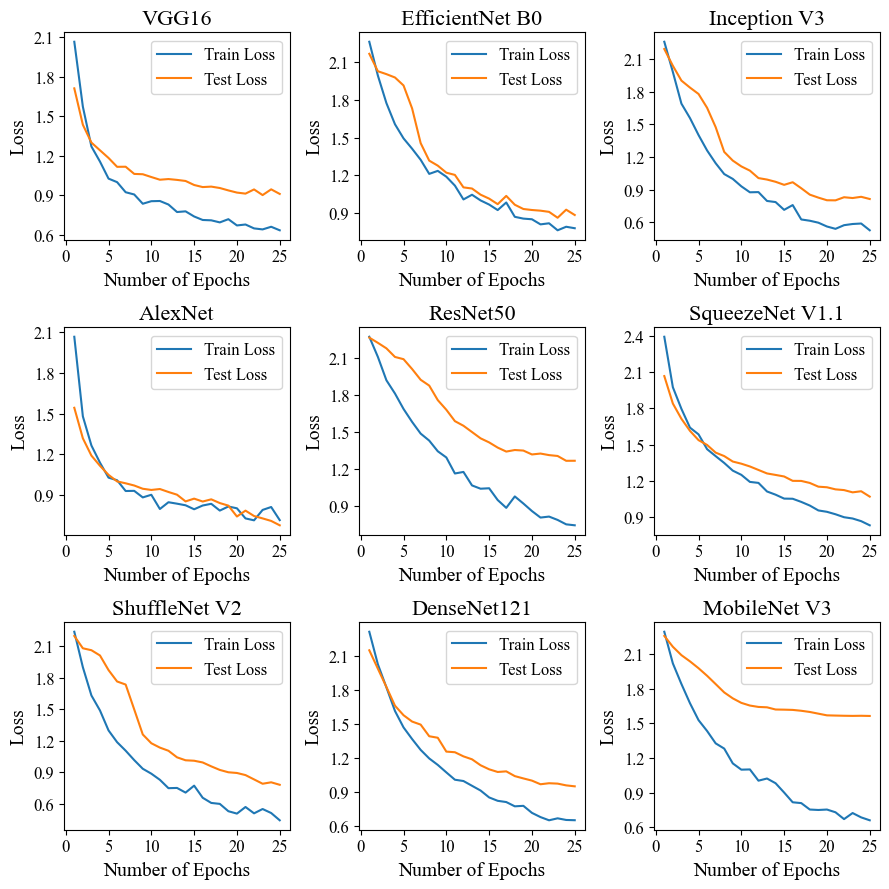

In [ ]:
# result_dir = "/results_acc/"
result_dir = "/results18/"
names = ["vgg16", "eff", "inc", "alex", "res50", "squ", "shu", "den", "mob"]
modelnames = [
    "VGG16", "EfficientNet B0", "Inception V3", "AlexNet", "ResNet50",
    "SqueezeNet V1.1", "ShuffleNet V2", "DenseNet121", "MobileNet V3"
]

def draw_loss(working_dir, result_dir, save_dir = False):
  """
  Draw train & test loss figures.

  Input:
  working_dir - the working directory;
  result_dir - the directory where the results are saved;
  save_dir - default = False, the directory where the figure is going to be saved;

  Output:
  None, but generate (and save) the loss graph."""

  fontsize_subtitle = 16
  fontsize_axis = 14
  fontsize_tick = 12
  fontsize_legend = 12

  fig, axes = plt.subplots(3, 3, figsize=(9, 9))
  for i in range(len(names)):
    temp = pd.read_csv(working_dir + result_dir + names[i] + "_training_stats.csv")
    train_loss = temp[temp["phase"] == "train"]["loss"]
    test_loss = temp[temp["phase"] == "test"]["loss"]
    epochs = temp[temp["phase"] == "test"]["epoch"]
    epochs = epochs + 1 # +1 so that the value starts from 1 instead of 0

    row = i // 3
    col = i % 3

    axes[row, col].plot(epochs, train_loss, label = "Train Loss")
    axes[row, col].plot(epochs, test_loss, label = "Test Loss")

    axes[row, col].legend(fontsize = fontsize_legend)

    axes[row, col].set_xlabel("Number of Epochs", fontsize = fontsize_axis)
    axes[row, col].tick_params(axis="x", labelsize = fontsize_tick)
    x_major_locator = plt.MultipleLocator(5)
    axes[row, col].xaxis.set_major_locator(x_major_locator)

    axes[row, col].set_ylabel("Loss", fontsize = fontsize_axis)
    axes[row, col].tick_params(axis="y", labelsize = fontsize_tick)
    y_major_locator = plt.MultipleLocator(0.3)
    axes[row, col].yaxis.set_major_locator(y_major_locator)

    axes[row, col].set_title(modelnames[i], fontsize = fontsize_subtitle)

  fig.tight_layout()
  plt.rcParams["font.family"] = "Times New Roman"

  if save_dir:
    plt.savefig(working_dir + save_dir + "/loss.pdf", dpi = 300,
                bbox_inches = "tight")

  plt.show()

draw_loss(wd, result_dir, save_dir = "/results_acc")

## Compute Accuracy

In [ ]:
model_dir = "/results_acc"
data_dir = "/dataset_acc_test"
data_dir2 = "/dataset_acc_test1"

v_nums = list(range(3, 13))

models = [model1, model2, model3, model4, model5, model6, model7, model8, model9]
weights = [weights1, weights2, weights3, weights4, weights5, weights6, weights7,
           weights8, weights9]
names = ["vgg16", "eff", "inc", "alex", "res50", "squ", "shu", "den", "mob"]

def change_model(model, model_name):
  """Freeze all parameters except those in the last layer(s) in a model.

  Input:
  model - the pre-trained model;
  model_name - the name of the model;

  Output:
  model - the same model but the parameters on the last layer(s) are unfrozen.
  """

  if model_name in ["vgg16", "eff", "alex", "mob"]:
      # define model
      num_features = list(model.classifier.children())[-1].in_features

      model.classifier = nn.Sequential(
          *list(model.classifier.children())[:-1] +
          [nn.Linear(num_features, len(v_nums))]
      )

  elif model_name == "inc":
    # define model
    num_features = model.fc.in_features

    model.fc = nn.Linear(num_features, len(v_nums))
    model.aux_logits = False

  elif model_name in ["res50", "shu"]:
      # define model
      num_features = model.fc.in_features

      model.fc = nn.Linear(num_features, len(v_nums))

  elif model_name in ["squ"]:
    # define model
    num_features = model.classifier[1].in_channels

    model.classifier = nn.Sequential(
        *([list(model.classifier.children())[0]] +
          [nn.Conv2d(num_features, len(v_nums), kernel_size=(1, 1), stride=(1, 1))] +
          list(model.classifier.children())[2:])
    )

  elif model_name == "den":
    # define model
    num_features = model.classifier.in_features

    model.classifier = nn.Linear(num_features, len(v_nums))

  return model


# compute the overall accuracy
for current_model, current_weights, current_name in zip(models[:2], weights[:2], names[:2]):
  current_model = change_model(current_model, current_name)
  current_model.load_state_dict(torch.load(wd + model_dir + "/" + current_name + "_tl.pth",
                                    map_location = torch.device("cpu")))
  acc_dict = predict_all_pictures(wd + data_dir, current_model, weights = current_weights,
                                  which_measure = 18)
  acc_df = pd.DataFrame(list(acc_dict.items()),
                        columns = ["removal percentage", "accuracy"])
  acc_df["removal percentage"] = [i / 10 for i in range(10)]
  acc_df.to_csv(wd + model_dir + "/" + current_name + "_acc.csv")


# compute the accuracy by class for each model
for current_model, current_weights, current_name in zip(models, weights, names):
  trained_model = load_variable(wd + model_dir + "/" + current_name + "_tl_cpu.txt") # on CPU
  acc_dict = predict_all_pictures(wd + model_dir, trained_model,
                                  weights = current_weights,
                                  which_measure = "acc_by_class")
  acc_dict.to_csv(wd + model_dir + "/" + current_name + "_acc_by_class.csv")

## Visualization of Results

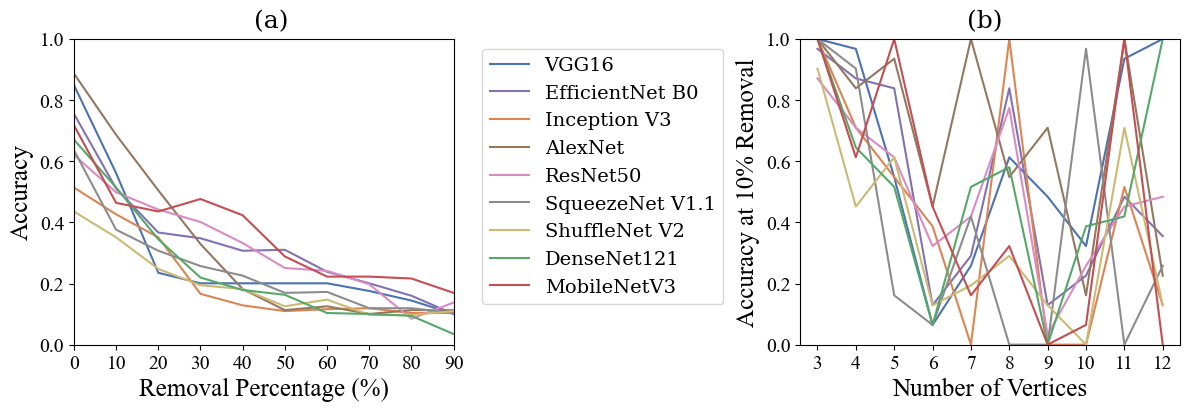

In [3]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import math

modelfile_names = ["vgg16", "eff", "inc", "alex", "res50", "squ", "shu", "den", "mob"]
model_names = ["VGG16", "EfficientNet B0", "Inception V3", "AlexNet", "ResNet50",
               "SqueezeNet V1.1", "ShuffleNet V2", "DenseNet121", "MobileNetV3"]


# draw line graph
def draw_line_graph_18(working_dir, result_dir,
                       save_dir = False):

  # create plots
  fig, ax = plt.subplots(1, 2, figsize = (12, 4))

  # color setting
  colors = sns.color_palette("deep", len(model_names))

  for filename in os.listdir(wd + result_dir):
    # determine model name
    find_match = re.search(r"(.*?)_acc.txt", filename)
    if (not find_match) or filename.startswith("k_"):
      continue

    # set color
    color_id = modelfile_names.index(find_match.group(1))

    model_name = model_names[color_id]

    # read data (saved as dictionary)
    acc_dict = load_variable(working_dir + result_dir + "/" + filename)

    keys = list(acc_dict.keys())
    values = list(acc_dict.values())
    ax[0].plot(keys, values, label = model_name, color = colors[color_id])

    acc_df2 = pd.read_csv(working_dir + "/dataset18_0319_incomplete/line/" +
                          modelfile_names[color_id] + "_acc_by_class.csv") # saved as csv
    acc_p1 = acc_df2.loc[0, ["3", "4", "5", "6", "7", "8", "9", "0", "1", "2"]]

    ax[1].plot(acc_p1, color = colors[color_id])

  # settings
  plt.rcParams["font.family"] = "DejaVu Serif"
  plt.subplots_adjust(wspace = 0.75)

  ax[0].legend(loc = "upper left", bbox_to_anchor = (1.05, 1),
            labels = model_names, fontsize = 14)
  ax[0].set_ylim(0.0, 1.0)
  ax[0].set_ylabel("Accuracy", fontsize = 18)
  ax[0].set_xticks(["p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"],
            [0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
  ax[0].set_xlim(0, 9)
  ax[0].set_xlabel("Removal Percentage (%)", fontsize = 18)
  ax[0].tick_params(axis = 'both', labelsize = 14)

  ax[1].set_ylim(0.0, 1.0)
  ax[1].set_ylabel("Accuracy at 10% Removal", fontsize = 18)
  ax[1].set_xticks(["3", "4", "5", "6", "7", "8", "9", "0", "1", "2"],
                   list(range(3, 13)))
  ax[1].set_xlabel("Number of Vertices", fontsize = 18)
  ax[1].tick_params(axis = 'both', labelsize = 14)

  fig.text(0.23, 0.99, "(a)", ha = "center", va = "center", fontsize = 18)
  fig.text(0.825, 0.99, "(b)", ha = "center", va = "center", fontsize = 18)

  plt.tight_layout()

  if save_dir:
    plt.savefig(working_dir + save_dir + "/results4_new.pdf", dpi = 200,
                bbox_inches = "tight")

  plt.show()

draw_line_graph_18(wd, "/results18", save_dir = "/results18")